# Scikit-downscale

## Prepare models

This first cell just imports some libraries and get's things setup for our analysis to come.This first cell just imports some libraries and get's things setup for our analysis to come.

In [1]:
# close warming info
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import numpy as np

from utils import get_sample_data

sns.set(style='darkgrid')

In the cell below, we'll create nine different downscaling models, some from Scikit-downscale and some from Scikit-learn.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation
from skdownscale.pointwise_models import QuantileMappingReressor

models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0),
    'GARD: QuantileMappingRegressor': QuantileMappingReressor()
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')


## Make a choice of the downscale model

In [56]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
# model = PointWiseDownscaler(RandomForestRegressor(random_state=0))
# model = PointWiseDownscaler(PureAnalog(kind='best_analog', n_analogs=1))
# model = PointWiseDownscaler(PureAnalog(kind='sample_analogs', n_analogs=10))
# model = PointWiseDownscaler(QuantileMappingReressor())

model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    BcsdTemperature(return_anoms=False)

## Malaysia/Philippines/Thailand/Indonesia

In [174]:
# NINO 3.4
NNN,SSS,WWW,EEE = 5.,-5.,-170.,-120.

# bounding box of downscaling region
lon_slice = slice(WWW, EEE) 
lat_slice = slice(NNN, SSS)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

Set the downscale resolution here. Example: CHANGE_INTERVAL=0.02 is for a resolution of 1deg*0.02~2km

In [ ]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
# cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
#                  grid_label='gn')
cat = col.search(experiment_id=['historical','ssp585'], table_id='Omon', variable_id='tos',member_id='r1i1p1f1',
                 grid_label='gn',institution_id='CSIRO-ARCCSS')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20210317


In [229]:
import intake_esm
import intake

train_slice = slice('1980', '2010')
holdout_slice = slice('2020', '2050')
lat_slice = slice(-5,5)
lon_slice = slice(190,240)

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
# cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
#                  grid_label='gn')
cat = col.search(experiment_id=['historical','ssp585'], table_id='Amon', variable_id='tasmax',member_id='r1i1p1f1',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn'].to_dask().squeeze(drop=True).drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
# ds_model.lon.values[ds_model.lon.values > 180] -= 360
# ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice,lat=lat_slice,lon=lon_slice)
# train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
# # train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
# train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


# # access the data and do some cleanup
ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn'].to_dask().squeeze(drop=True).drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
# ds_model.lon.values[ds_model.lon.values > 180] -= 360
# ds_model = ds_model.roll(lon=72, roll_coords=True)

holdout_subset = ds_model['tasmax'].sel(time=holdout_slice,lat=lat_slice,lon=lon_slice)
# holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
# # holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
# holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# # display
# # display(train_subset)
# # train_subset.isel(time=0).plot()
display(train_subset)
display(holdout_subset)
# holdout_subset.isel(time=0).plot()

<xarray.DataArray 'tasmax' (time: 372, lat: 8, lon: 27)>
dask.array<getitem, shape=(372, 8, 27), dtype=float32, chunksize=(198, 8, 27), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -4.375 -3.125 -1.875 -0.625 0.625 1.875 3.125 4.375
  * lon      (lon) float64 190.3 192.2 194.1 195.9 ... 233.4 235.3 237.2 239.1
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 ... 2010-12-16T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum within days time: mean over days
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-08T07:07:01Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

<xarray.DataArray 'tasmax' (time: 372, lat: 8, lon: 27)>
dask.array<getitem, shape=(372, 8, 27), dtype=float32, chunksize=(372, 8, 27), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -4.375 -3.125 -1.875 -0.625 0.625 1.875 3.125 4.375
  * lon      (lon) float64 190.3 192.2 194.1 195.9 ... 233.4 235.3 237.2 239.1
  * time     (time) datetime64[ns] 2020-01-16T12:00:00 ... 2050-12-16T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum within days time: mean over days
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-08T03:12:27Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

Check the available CMIP6 models

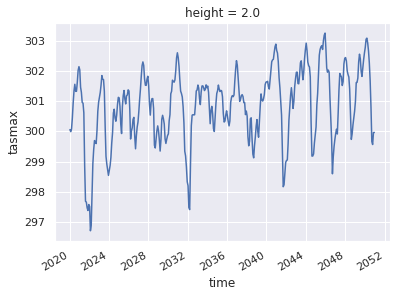

In [230]:
holdout_subset.mean(['lat','lon']).plot()

In [231]:
EMI = pd.read_csv('./EMI_MONTHLY_ANOMALY.csv')
EMI = EMI[(EMI.YR>=1980)&(EMI.YR<=2010)]
EMI.head(-10)

,YR,MON,EMI
1320,1980,1,0.497803
1321,1980,2,0.629508
1322,1980,3,0.399472
1323,1980,4,0.322660
1324,1980,5,0.236500
...,...,...,...
1677,2009,10,0.593165
1678,2009,11,0.858335
1679,2009,12,0.777416
1680,2010,1,0.880081


In [232]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation, QuantileMappingReressor


model = {
    # 'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    # 'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    # 'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    # 'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    # 'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    # 'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    # 'GARD: LinearRegression': LinearRegression(),
    # 'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    # 'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

model = QuantileMappingReressor()

In [233]:
import scipy.signal
model.fit(scipy.signal.detrend(train_subset.mean(['lat','lon']).values).reshape(-1,1), scipy.signal.detrend(EMI.EMI.values).reshape(-1,1)) # training, obs

QuantileMappingReressor()

In [234]:
predicted = model.predict(scipy.signal.detrend(holdout_subset.mean(['lat','lon']).values).reshape(-1,1)) # prediction
nowdays   = model.predict(scipy.signal.detrend(train_subset  .mean(['lat','lon']).values).reshape(-1,1))

In [235]:
ENSO = pd.DataFrame(index=holdout_subset.time,columns=['ENSO'],data=predicted)

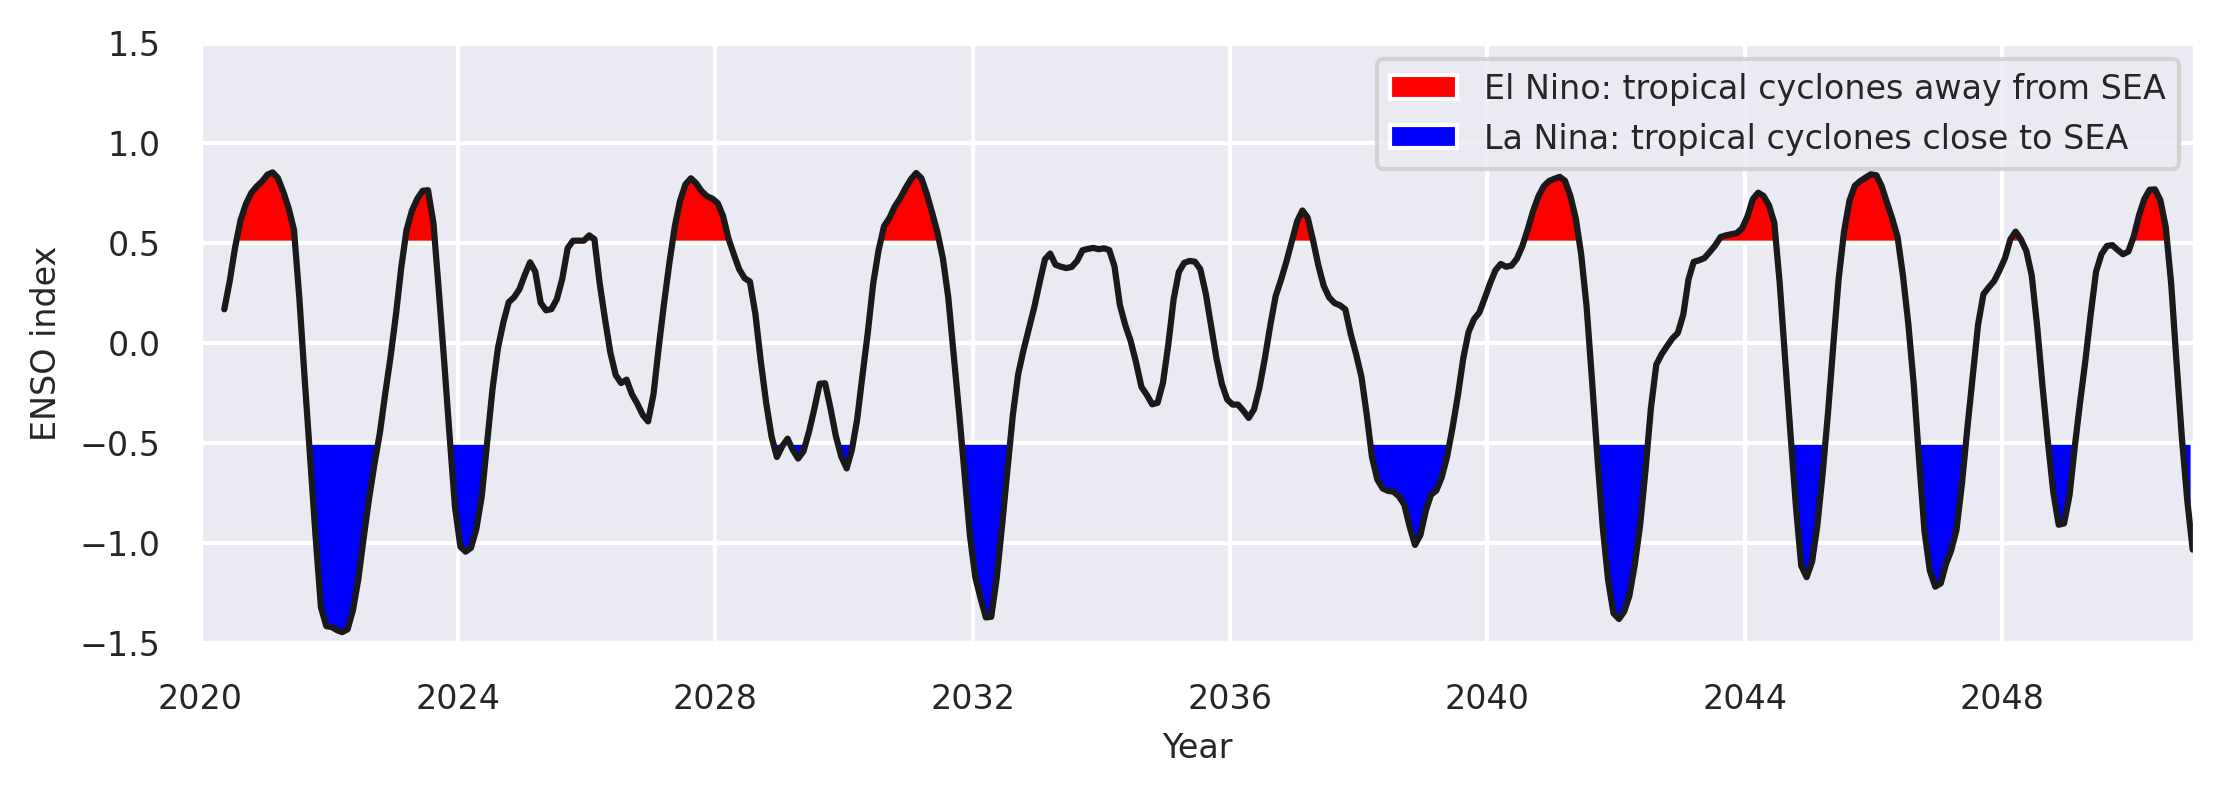

In [236]:
N=5

fig,ax=plt.subplots(1,1); fig.set_size_inches(7,2); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

tmp_Y = ENSO.rolling(window=N).mean()
tmp_X = ENSO.index 

_=ax.plot(tmp_X,tmp_Y,'-k')
_=ax.set_ylim([-1.5,1.5])
_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
tmptmp = np.zeros(tmp_Y.shape).reshape(1,-1)+.5
_=ax.fill_between(tmp_X,tmptmp[0],tmp_Y.ENSO.values.reshape(1,-1)[0],where=tmptmp[0]<=tmp_Y.ENSO.values.reshape(1,-1)[0],facecolor='red', interpolate=True,label='El Nino: tropical cyclones away from SEA')
tmptmp = np.zeros(tmp_Y.shape).reshape(1,-1)-.5
_=ax.fill_between(tmp_X,tmptmp[0],tmp_Y.ENSO.values.reshape(1,-1)[0],where=tmptmp[0]>=tmp_Y.ENSO.values.reshape(1,-1)[0],facecolor='blue', interpolate=True,label='La Nina: tropical cyclones close to SEA')
_=ax.legend(fontsize=fontsize)
_=ax.set_ylabel('ENSO index',fontsize=fontsize)
_=ax.set_xlabel('Year',fontsize=fontsize)
import datetime
_=ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2050, 12, 31)])